# Crime Data

This notebook was loaded with:

```bash
PYSPARK_DRIVER_PYTHON=jupyter PYSPARK_DRIVER_PYTHON_OPTS=notebook ./dse/bin/dse pyspark --num-executors 5 --driver-memory 6g --executor-memory 6g
```

The general plan is to do some exploration and cleaning in jupyter notebooks, then run our actual models by submitting python scripts and letting the jobs run as we'd expect.

We'll clean the data and load them into cassandra tables to be used by the jobs.

In [1]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import isnull, count, datediff, lag, sum, coalesce, rank, lit, when,col, udf, to_date, year, mean, month, date_format, array
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, DateType
from pyspark.ml.feature import StringIndexer
from datetime import datetime
from pyspark.sql.window import Window
import pyspark
import matplotlib
import matplotlib.pyplot as plt

Crime data is a little unique... there's a TON of it. The data file alone is 1.5GB. So, we'll need to be discriminating in what we keep.

The full data set can be downloaded here. It's not in the github repo given its size. https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2

We'll use pandas for this one. Spark isn't the right tool for the exploration. We'll do a bit of cleaning before we even give it to spark.

In [3]:
import pandas as pd
df_crimes = pd.read_csv('data/Crimes_-_2001_to_present.csv')

In [4]:
# Transform column headers to lower case
df_crimes.columns = map(str.lower, df_crimes.columns)

# Replace whitespace in headers
df_crimes.columns = [x.strip().replace(' ', '_') for x in df_crimes.columns]

In [5]:
df_crimes = df_crimes[(df_crimes['year'] > 2009) & (df_crimes['year'] < 2017) & (df_crimes['domestic'] == False)]

In [6]:
df_crimes.head()

,id,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location
31,10513810,HZ255565,05/07/2016 08:50:00 PM,022XX W AUGUSTA BLVD,0820,THEFT,$500 AND UNDER,RESIDENTIAL YARD (FRONT/BACK),False,False,...,32.0,24.0,06,1161255.0,1906619.0,2016,05/14/2016 03:53:39 PM,41.899447,-87.683155,"(41.899446681, -87.683155475)"
75,10513811,HZ255484,05/07/2016 07:00:00 PM,084XX S WHIPPLE ST,0460,BATTERY,SIMPLE,PARK PROPERTY,False,False,...,18.0,70.0,08B,1157569.0,1848672.0,2016,05/14/2016 03:53:39 PM,41.740509,-87.698267,"(41.740508709, -87.698267243)"
118,10513812,HZ255513,05/07/2016 07:35:00 PM,022XX S KIRKLAND AVE,041A,BATTERY,AGGRAVATED: HANDGUN,STREET,False,False,...,22.0,29.0,04B,1147705.0,1888667.0,2016,05/14/2016 03:53:39 PM,41.850455,-87.733386,"(41.850455293, -87.733385719)"
162,10513813,HZ255586,05/07/2016 08:00:00 PM,030XX S DRAKE AVE,2220,LIQUOR LAW VIOLATION,ILLEGAL POSSESSION BY MINOR,SIDEWALK,True,False,...,22.0,30.0,22,1153183.0,1884181.0,2016,05/14/2016 03:53:39 PM,41.838038,-87.713399,"(41.838038379, -87.713399152)"
663,10513814,HZ255458,05/07/2016 06:30:00 PM,021XX W 19TH ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,CHA APARTMENT,False,False,...,25.0,31.0,08B,1162430.0,1890722.0,2016,05/14/2016 03:53:39 PM,41.855799,-87.679285,"(41.855799401, -87.679284674)"


In [7]:
df_crimes = df_crimes.drop('description', 1)
df_crimes = df_crimes.drop('location', 1)
df_crimes = df_crimes.drop('location_description', 1)
df_crimes = df_crimes.drop('x_coordinate', 1)
df_crimes = df_crimes.drop('y_coordinate', 1)
df_crimes = df_crimes.drop('updated_on', 1)
df_crimes = df_crimes.drop('domestic', 1)

In [8]:
# Exclude NA's
df_crimes = df_crimes[~pd.isnull(df_crimes['latitude'])]
# Exclude NA's
df_crimes = df_crimes[~pd.isnull(df_crimes['longitude'])]

Save it locally just to get a feel for the size (and gives you something to use if you want to play with it.. and don't want to load 1.5GB).

In [10]:
df_crimes.to_csv('data/crimes_2010-2016.csv')

In [12]:
#--------  Scatter Plot
# A function that visualizes the data
# Input: 
#      x (variable on the x-axis)
#      y (variable on the y_axis)
#      df (panda data frame)
#      group (grouping variable, i.e., variable to plot)
#      col (vector of colors)
#      alpha (alpha value for colors)
#      size (size of the dots)
#      title (title of the plot)
#      marker (shape of the marker, default to 'o')
#      add_line (add a line plot)
#      linewidth (thinkness of the added line)
#      figsize (size of the figure)

def scatter_plot(x, y, my_df, group, color, alpha, size, title, marker='o', add_line=False, linewidth=1, figsize=(15, 10)):
    
    # Define plot
    fig = plt.figure(figsize=figsize)
    ax = plt.axes()

    # Extract unique categories
    cat = my_df[group].unique()

    # Loop trough categories
    for i in range(0, len(cat)) :
            ax.scatter(my_df[x][my_df[group] == cat[i]].values,
                       my_df[y][my_df[group] == cat[i]].values,
                       alpha=alpha, edgecolors="None", s=size, c=color,
                       label=cat[i],
                       marker=marker)
    # Add line plot
    if add_line:
            for i in range(0, len(cat)) :
                ax.plot(my_df[x][my_df[group] == cat[i]].values,
                           my_df[y][my_df[group] == cat[i]].values,
                           alpha=alpha, linewidth=linewidth)

    # Add legend, grid etc.
    ax.legend(loc='best', scatterpoints = 1) # Legend with just one dot
    ax.set_xlabel(x); ax.set_ylabel(y)
    ax.set_title(title)
    plt.grid()

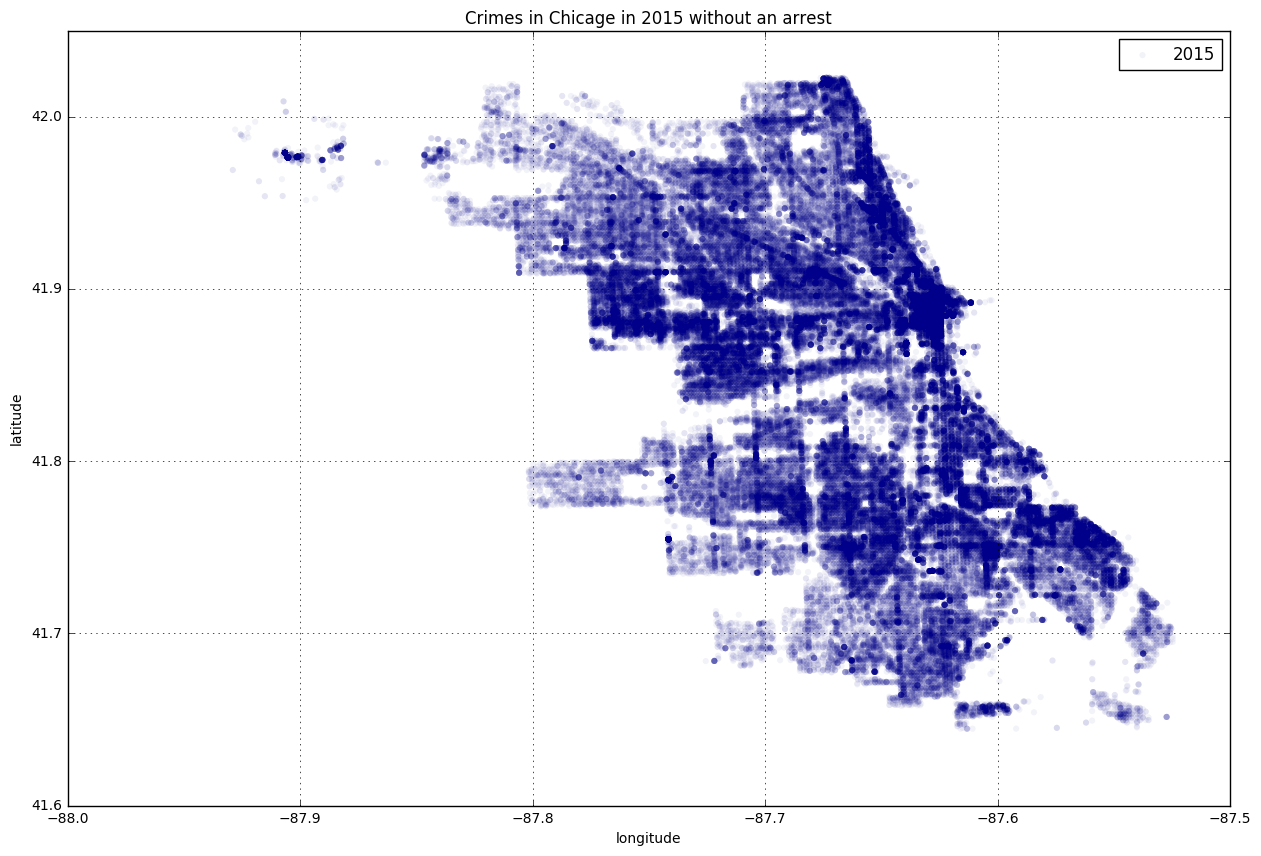

In [13]:
# Plot the data
#col = ["darkblue", "darkred"]
scatter_plot(x='longitude', y='latitude', my_df=df_crimes[(df_crimes['arrest'] == False) & (df_crimes['year']==2015)], group='year',
             color='darkblue',alpha=0.05, size=20, marker='o',
             title="Crimes in Chicage in 2015 without an arrest")

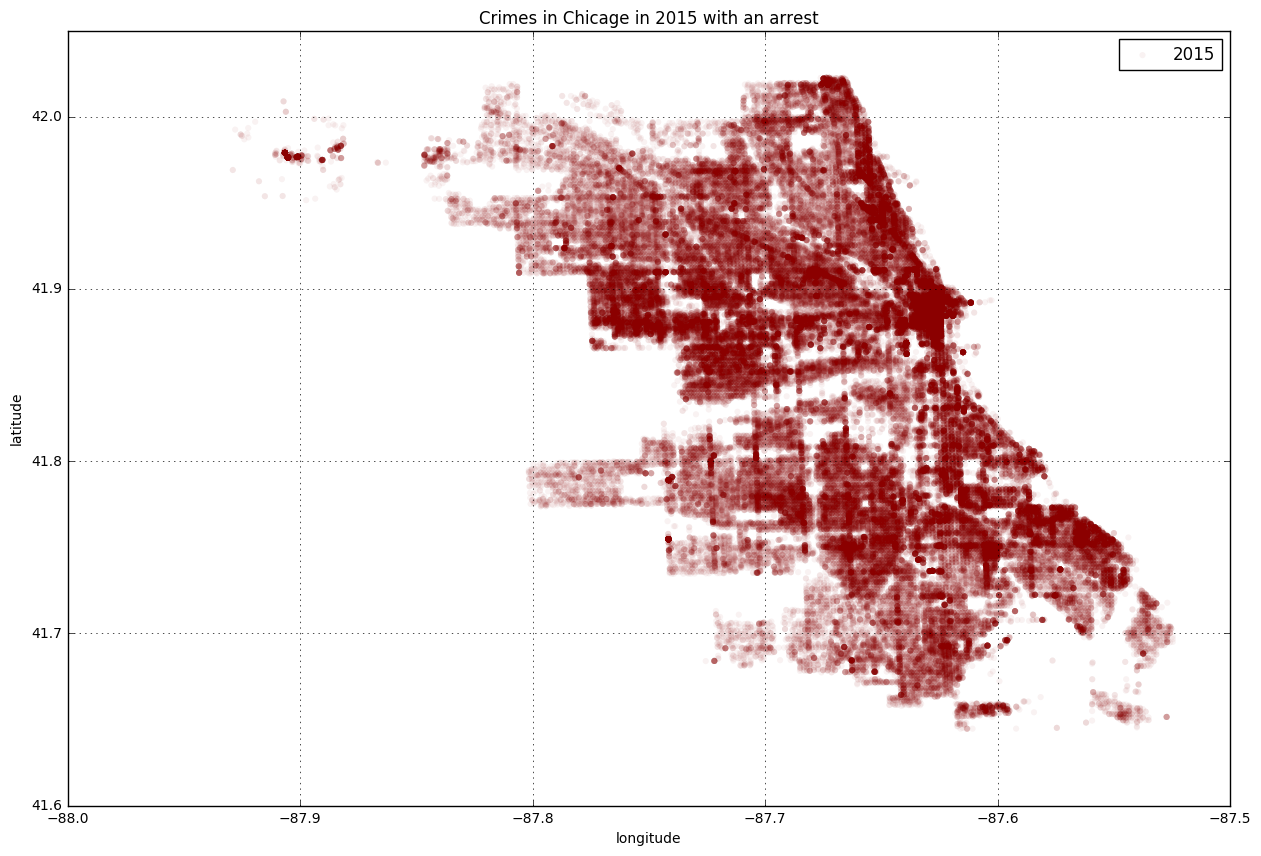

In [14]:
# Plot the data
scatter_plot(x='longitude', y='latitude', my_df=df_crimes[(df_crimes['arrest'] == False) & (df_crimes['year']==2015)], group='year',
             color='darkred',alpha=0.05, size=20, marker='o',
             title="Crimes in Chicage in 2015 with an arrest")

crimes overlayed with location of violations
violations with an index for each kind of crime, or a count of each crime
kinds of crimes

In [15]:
#--------  Bar Plot
# A function to create a barplot
# Input: 
#      df (panda data frame)
#      var_name (name of the variable)
#      alpha (alpha value [0, 1])
#      title (title of the function)
#      color (color of the barplot)
#      edgecolor (cor of the outer barplotlines)
#      figsize (size of the figure)

def bar_plot(my_df, var_name, color='darkblue', alpha=0.6, title='', edgecolor='white', figsize=(18, 6)):
    
    ## Analyse crime types
    my_df['count'] = 1
    group = my_df.groupby(var_name)
    group = group.sum()
    group = group.sort_values('count', ascending=False)
    group = group['count']

    # Plot
    plt = group.plot(kind='bar', figsize=figsize, color=color, alpha=alpha, edgecolor=edgecolor, title=title)
    plt.grid()

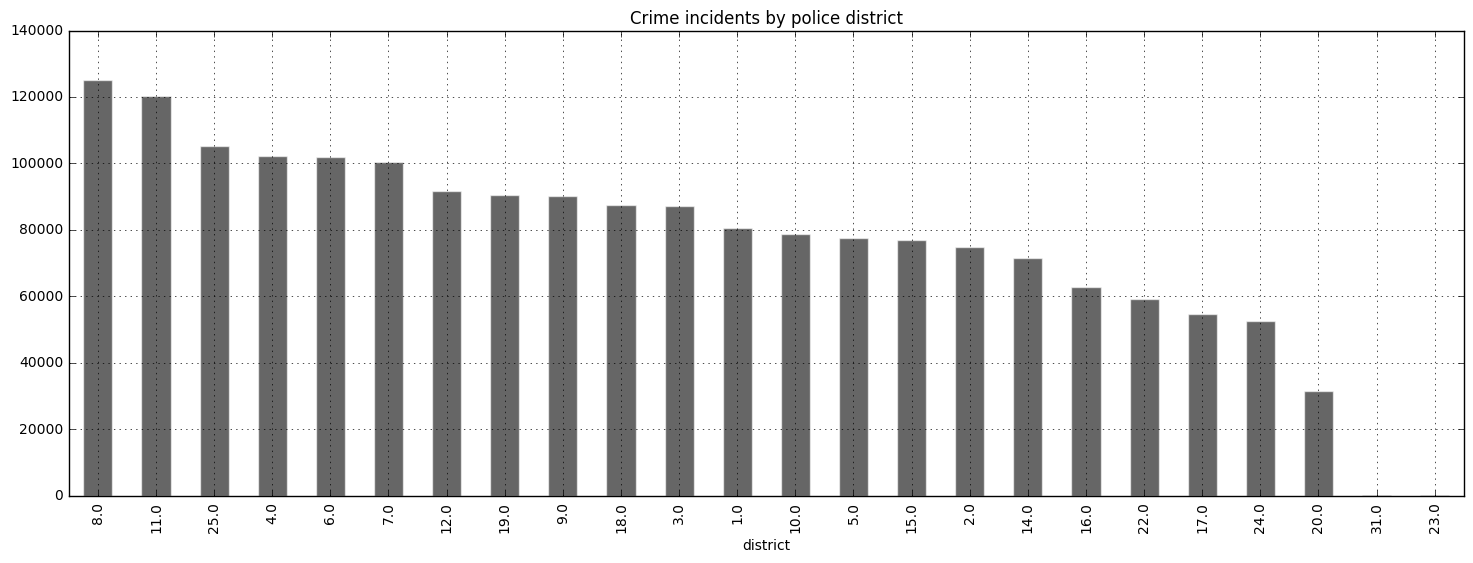

In [16]:
bar_plot(my_df=df_crimes, var_name='district', color='black', alpha=0.6,
         title='Crime incidents by police district', edgecolor='white', figsize=(18, 6))

District 8, 11 & 25 top the list of incidents (in all charts). We'll need to see how they do against inspections.

/Users/angelo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


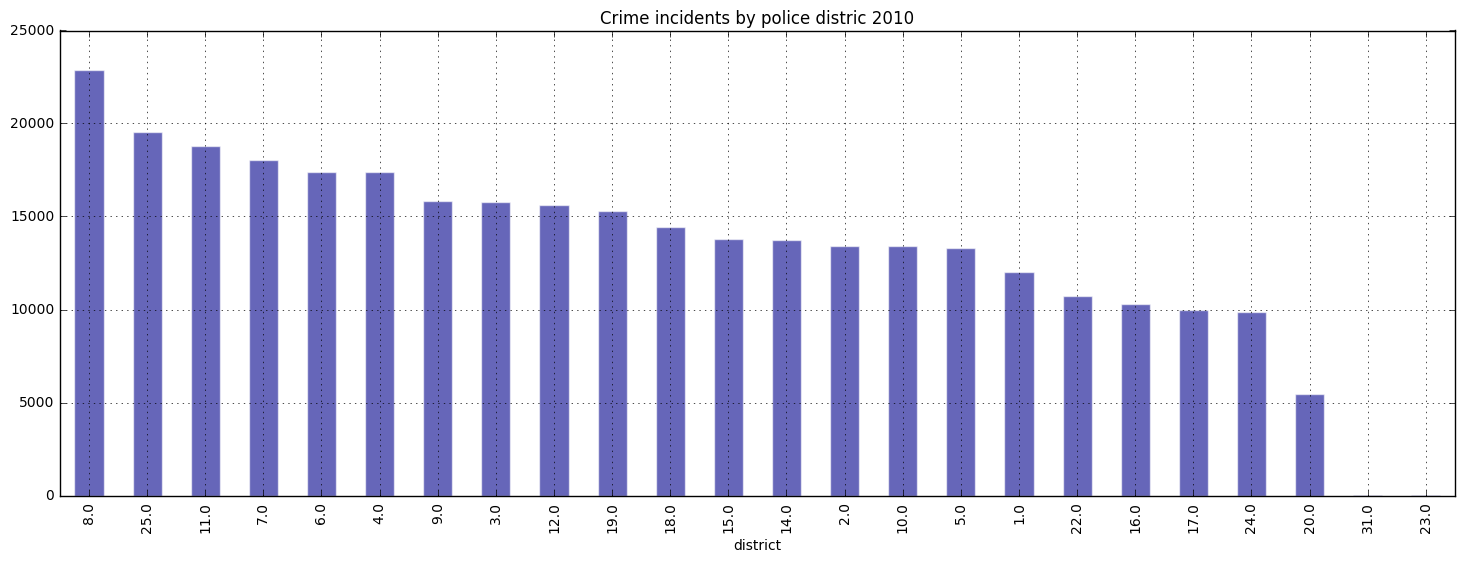

In [19]:
bar_plot(my_df=df_crimes[df_crimes['year']==2010], var_name='district', color='darkblue', alpha=0.6,
         title='Crime incidents by police distric 2010', edgecolor='white', figsize=(18, 6))

/Users/angelo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


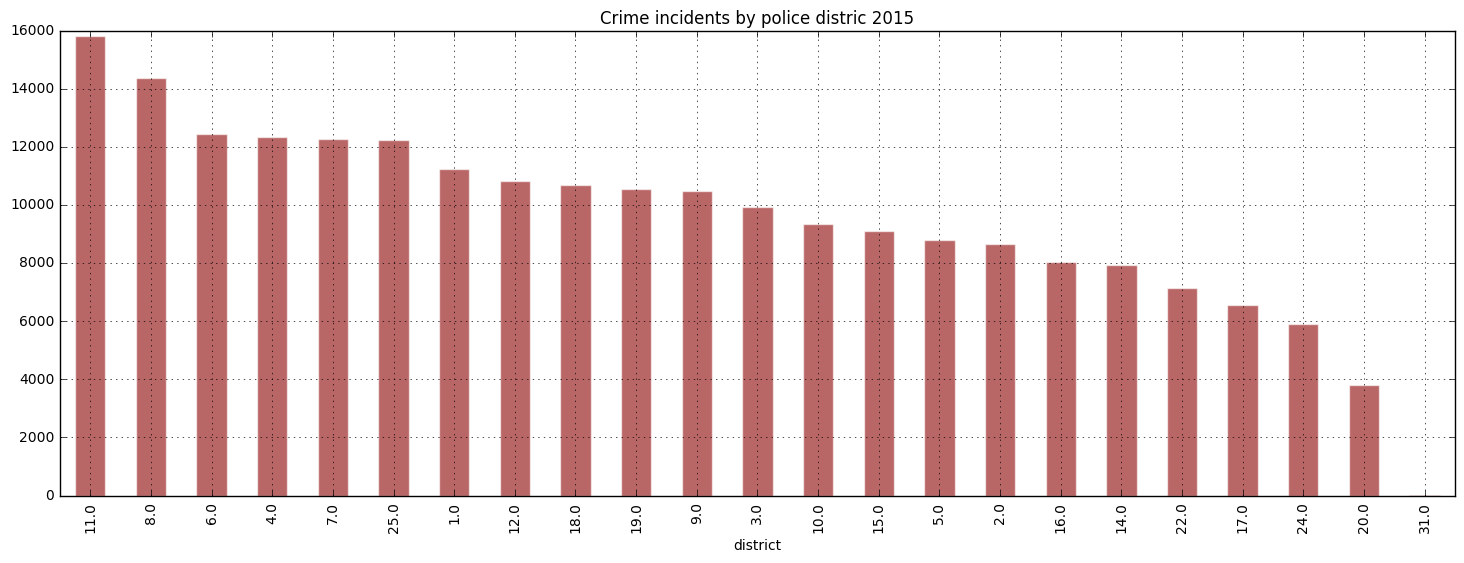

In [20]:
bar_plot(my_df=df_crimes[df_crimes['year']==2015], var_name='district', color='darkred', alpha=0.6,
         title='Crime incidents by police distric 2015', edgecolor='white', figsize=(18, 6))

Overall, the same districts seem to top the lists throughout the years. We don't explore the year over year changes (although that may be an interesting model), but it's reasonable to aggregate and use the district data in the model.

In [19]:
df_crimes.dtypes

id                  int64
case_number        object
date               object
block              object
iucr               object
primary_type       object
arrest               bool
beat                int64
district          float64
ward              float64
community_area    float64
fbi_code           object
year                int64
latitude          float64
longitude         float64
count               int64
dtype: object

In [22]:
df_crimes.case_number = df_crimes.case_number.astype(str)
df_crimes.date = df_crimes.date.astype(str)
df_crimes.block = df_crimes.block.astype(str)
df_crimes.iucr = df_crimes.iucr.astype(str)
df_crimes.primary_type = df_crimes.primary_type.astype(str)
df_crimes.fbi_code = df_crimes.fbi_code.astype(str)
df_crimes.dtypes

id                  int64
case_number        object
date               object
block              object
iucr               object
primary_type       object
arrest               bool
beat                int64
district          float64
ward              float64
community_area    float64
fbi_code           object
year                int64
latitude          float64
longitude         float64
count               int64
dtype: object

In [23]:
df = sqlContext.createDataFrame(df_crimes)

In [26]:
df=df.drop("count")
df.dtypes

[('id', 'bigint'),
 ('case_number', 'string'),
 ('date', 'string'),
 ('block', 'string'),
 ('iucr', 'string'),
 ('primary_type', 'string'),
 ('arrest', 'boolean'),
 ('beat', 'bigint'),
 ('district', 'double'),
 ('ward', 'double'),
 ('community_area', 'double'),
 ('fbi_code', 'string'),
 ('year', 'bigint'),
 ('latitude', 'double'),
 ('longitude', 'double')]

Keep in mind that this is a very large job... > 2 million rows with about 500MB or data. If you kept the default values for cassandra, you'll likely timeout. You have a few options:
- Increase the timeout. It's not an unreasonable option for one of these one-time batch load operations.
- Decrease the memtable size and increase the frequency it's flushed to disk. You'll lose some performance, but you'll decrease the time the master should be waiting on the write process because the acknowledgment will happen more frequently.

```cql
CREATE  KEYSPACE chicago_data 
   WITH REPLICATION = {'class' : 'SimpleStrategy', 'replication_factor' : 1};
```

```cql
CREATE TABLE chicago_data.crime (
    id text,
    case_number text,
    date text,
    block text,
    iucr text,
    primary_type text,
    arrest boolean,
    beat text,
    district text,
    ward text,
    community_area text,
    fbi_code text,
    year text,
    latitude float,
    longitude float,
    PRIMARY KEY (id));
```

In [27]:
 df.write\
    .format("org.apache.spark.sql.cassandra")\
    .mode('append')\
    .options(table="crime", keyspace="chicago_data")\
    .save()

In [96]:
df.count()

1822721

Note: if you're running into read timeouts in cqlsh, be sure to check the values for the timeout there too (in the yaml file).

Another option is to look in the sstable stats for the chicago_data keyspace. You can do that by running this:

```bash
./nodetool cfstats
```

Then, in the chicago_data section, look for the Number of keys. It's not exact, but it's a close estimate.

```text
Keyspace : chicago_data
	Read Count: 1
	Read Latency: 1.188 ms.
	Write Count: 1822721
	Write Latency: 0.01918163613630391 ms.
	Pending Flushes: 0
		Table: crime
		SSTable count: 2
		Space used (live): 169088604
		Space used (total): 169088604
		Space used by snapshots (total): 0
		Off heap memory used (total): 2477081
		SSTable Compression Ratio: 0.5469334564722008
		Number of keys (estimate): 1806803
		Memtable cell count: 60249
		Memtable data size: 20753345
		Memtable off heap memory used: 0
		Memtable switch count: 8
        ...
```